In [1]:
import stablerank.srank as sr
from ripser import ripser

import _pickle as pickle

import numpy as np
inf=float("inf")

import pandas as pd

import itertools as it

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from scipy.spatial.distance import cdist, pdist, squareform


import scipy.stats as st

from sklearn import svm


from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from timeit import default_timer as timer
from datetime import timedelta

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

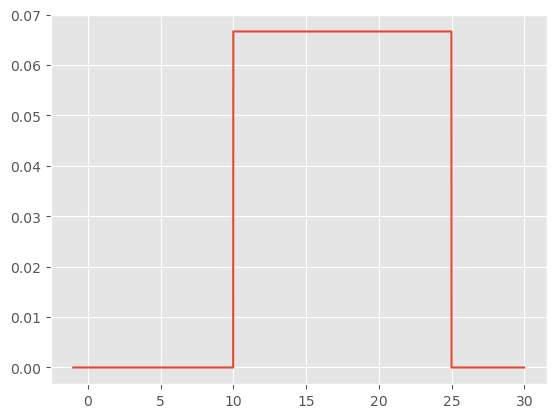

In [2]:
f = sr.get_distribution(name="uniform", interval=[10,25])
f.plot([-1,30])

In [3]:
w = [-1,4,5,6,10,21, 23, 28]
f(w)


array([0.        , 0.        , 0.        , 0.        , 0.33333333,
       0.33333333, 0.33333333, 0.        ])

## Wisconsin breast cancer

In [4]:
org_input = pd.read_csv("Data/breast-cancer-wisconsin.csv", sep=",", header=None).to_numpy()
input = np.empty(org_input.shape, dtype="double")
a = 0
j = 0
i = 0
while i < len(org_input):
    if org_input[i,5]!="?":
        j += 1
        a += np.double(org_input[i,5])
    i += 1
avg = a/j     
for i,x in np.ndenumerate(org_input):
    if x=="?":
        input[i]= avg
    else:
        input[i]= np.double(x)

data = input[:,:9]
classification = input[:,9]
number_data_points = len(classification)

In [5]:
print("number of patients: ", len(classification))
print("number of benign cases (class 2): ", len(np.where(classification==2)[0]))
print("number of malignant cases (class 4): ", len(np.where(classification==4)[0]))

number of patients:  699
number of benign cases (class 2):  458
number of malignant cases (class 4):  241


In [6]:
i = 0
print(data[i], classification[i])

[5. 1. 1. 1. 2. 1. 3. 1. 1.] 2.0


# Direct SVM classification

In [7]:
X_train, X_test, y_train, y_test = train_test_split(np.arange(len(data)), 
                                                    classification, 
                                                    test_size=0.8) #, random_state=42)
print("train size: ", len(X_train))
print("test size: ", len(X_test))

train size:  139
test size:  560


In [8]:
train = [data[i] for i in X_train]
test = [data[i] for i in  X_test]

start = timer()    

kernel_train = np.asarray([[np.dot(f,g) for g in train] for f in train])
kernel_test = np.asarray([[np.dot(f,g) for g in train] for f in test])

end = timer()
print(timedelta(seconds=end-start))

0:00:00.060996


In [9]:
clf = svm.SVC(kernel='precomputed')
clf.fit(kernel_train, y_train)
prediction = clf.predict(kernel_test )
a_score = accuracy_score(y_test, prediction)
print("classification accuracy: ", a_score)

classification accuracy:  0.9482142857142857


# Exploring the geometry using stable ranks

In [10]:
wisconsin_distances=squareform(pdist(data, "euclidean"))

In [11]:
distance = sr.Distance(wisconsin_distances)

(array([  1.,   0.,  28., 347., 142.,  50.,  64.,  41.,  17.,   9.]),
 array([ 0.        ,  2.463737  ,  4.927474  ,  7.391211  ,  9.854948  ,
        12.31868499, 14.78242199, 17.24615899, 19.70989599, 22.17363299,
        24.63736999]),
 <BarContainer object of 10 artists>)

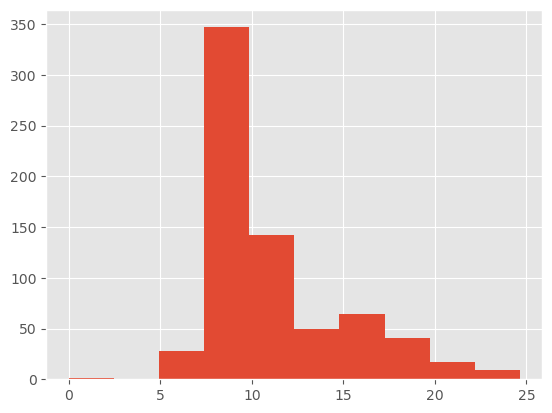

In [65]:
plt.hist(wisconsin_distances[6])


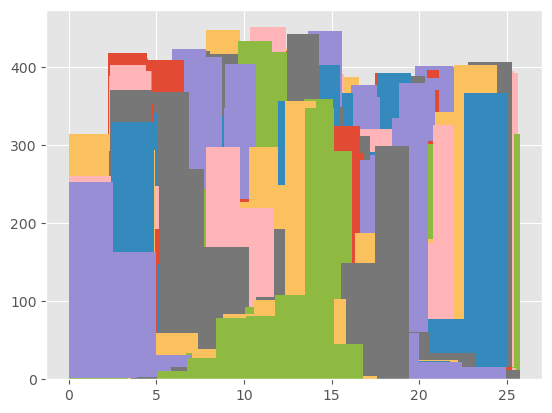

In [12]:
for i in range(number_data_points):
    plt.hist(wisconsin_distances[i])


In [13]:
distributions = {}
distributions["0_10"] = sr.get_distribution(name="uniform", interval=[0,10])
distributions["5_15"] = sr.get_distribution(name="uniform", interval=[5,15])
distributions["10_20"] = sr.get_distribution(name="uniform", interval=[10,20])
distributions["15_25"] = sr.get_distribution(name="uniform", interval=[15,25])
distributions["20_30"] = sr.get_distribution(name="uniform", interval=[20,30])


In [14]:
probabilities = {}
for k in distributions.keys():
    probabilities[k] = distributions[k](wisconsin_distances)

In [15]:
number_instances=500
sample_size=10

start = timer()    
h0_sr = {}
h1_sr = {}
for k in  distributions.keys():
    h0_sr[k] = []
    h1_sr[k] = []
    for patient in wisconsin_distances:
        p = distributions[k](patient)
        s = sr.get_sample(number_instances, sample_size, p)
        f = distance.get_h0sr(sample=s,clustering_method="complete")
        b = distance.get_bc(sample=s, maxdim=1)
        g = sr.bc_to_sr(b,degree="H1")
        h0_sr[k].append(f)
        h1_sr[k].append(g)
end = timer()
print(timedelta(seconds=end-start))                      

0:04:18.827619


In [ ]:
h0_modeling = []
h1_modeling = []
for i in range(number_data_points):
    h0 = []
    h1 = []
    for k in  distributions.keys():
        h0.append(h0_sr[k][i])
        h1.append(h1_sr[k][i])
    h0_modeling.append(h0)
    h1_modeling.append(h1)

In [67]:
number_distributions = len(distributions)
@widgets.interact(x=(0, number_data_points-1, 1))
def plot(x):
    if classification[x] ==2:
        color = "black"
    else:
        color = "red"
            
    for k in  distributions.keys():
        h1_sr[k][x].plot(color=color, linewidth=0.6)
    plt.title("H1 stable ranks for patient: "+str(x))


interactive(children=(IntSlider(value=349, description='x', max=698), Output()), _dom_classes=('widget-interac…

# Fitting SVM to homological representation

In [18]:
h0_kernel_train = {}
h0_kernel_test = {}
h0_prediction = {}
h0_a_score = {}
start = timer()  

for k in distributions.keys():
    h0_train = [h0_sr[k][i] for i in X_train]
    h0_test = [h0_sr[k][i] for i in X_test]
    kernel_train = np.asarray([[f.dot(g) for g in h0_train] for f in h0_train])
    kernel_test = np.asarray([[f.dot(g) for g in h0_train] for f in h0_test])
    h0_kernel_train[k] = kernel_train
    h0_kernel_test[k] = kernel_test
    clf = svm.SVC(kernel='precomputed')
    clf.fit(kernel_train, y_train)
    pred = clf.predict(kernel_test )
    h0_prediction[k] = pred
    h0_a_score[k] = accuracy_score(y_test, pred)
    print(k)
end = timer()
print("h0 pred: ", timedelta(seconds=end-start))



h1_kernel_train = {}
h1_kernel_test = {}
h1_prediction = {}
h1_a_score = {}

start = timer()  

for k in distributions.keys():
    h1_train = [h1_sr[k][i] for i in X_train]
    h1_test = [h1_sr[k][i] for i in X_test]
    kernel_train = np.asarray([[f.dot(g) for g in h1_train] for f in h1_train])
    kernel_test = np.asarray([[f.dot(g) for g in h1_train] for f in h1_test])
    h1_kernel_train[k] = kernel_train
    h1_kernel_test[k] = kernel_test
    clf = svm.SVC(kernel='precomputed')
    clf.fit(kernel_train, y_train)
    pred = clf.predict(kernel_test )
    h1_prediction[k] = pred
    h1_a_score[k] = accuracy_score(y_test, pred)
    print(k)
end = timer()
print("h1 pred: ", timedelta(seconds=end-start))

0_10
5_15
10_20
15_25
20_30
h0 pred:  0:00:49.352244
0_10
5_15
10_20
15_25
20_30
h1 pred:  0:00:53.373503


In [19]:
for k in h0_a_score.keys():
    print("distribution "+k+", h0 score:", round(h0_a_score[k],2), 
          ", h1 score:", round(h1_a_score[k],2))


distribution 0_10, h0 score: 0.96 , h1 score: 0.95
distribution 5_15, h0 score: 0.95 , h1 score: 0.66
distribution 10_20, h0 score: 0.93 , h1 score: 0.93
distribution 15_25, h0 score: 0.95 , h1 score: 0.91
distribution 20_30, h0 score: 0.96 , h1 score: 0.95


In [20]:
h0_wrong_class = {}
for k in  distributions.keys():
    h0_wrong_class[k] = {}
    indx = []
    values = []
    pred = []
    for i in range(len(h0_prediction[k])):
        v = y_test[i]
        p = h0_prediction[k][i]
        if v != p:
            indx.append(i)
            values.append(v)
            pred.append(p)
        h0_wrong_class[k]["index"] = indx
        h0_wrong_class[k]["value"] = values
        h0_wrong_class[k]["prediction"] = pred

h1_wrong_class = {}
for k in  distributions.keys():
    h1_wrong_class[k] = {}
    indx = []
    values = []
    pred = []
    for i in range(len(h1_prediction[k])):
        v = y_test[i]
        p = h1_prediction[k][i]
        if v != p:
            indx.append(i)
            values.append(v)
            pred.append(p)
        h1_wrong_class[k]["index"] = indx
        h1_wrong_class[k]["value"] = values
        h1_wrong_class[k]["prediction"] = pred

In [23]:
print(h0_wrong_class["0_10"]['index'])
print(h0_wrong_class["20_30"]['index'])

[60, 100, 102, 108, 118, 128, 134, 190, 195, 223, 252, 258, 285, 351, 392, 410, 448, 490, 496, 506, 511, 521, 524, 533]
[0, 22, 92, 98, 102, 108, 191, 195, 223, 228, 276, 283, 300, 351, 392, 398, 410, 496, 506, 558]


In [46]:
acm_prediction = []
for i in range(len(X_test)):
    out = []
    for k in  distributions.keys():
        out.append(h0_prediction[k][i])
        out.append(h1_prediction[k][i])
    acm_prediction.append(out)

In [47]:
print(acm_prediction[4])

[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]


In [70]:
prediction = []
for acm_p in acm_prediction:
    score = 0
    for i in range(10):
        if acm_p[i]==4:
            score += 1
    if score>=5:
        prediction.append(4)
    else:
        prediction.append(2)
        
score = accuracy_score(y_test, prediction)
print(round(score,2))

0.97


In [25]:
number_distributions = len(distributions)
@widgets.interact(x=(0, number_distributions-1, 1))
def plot(x):
    i = 0
    k = list(distributions.keys())[x]
    for f in h0_sr[k]:
        if classification[i] ==2:
            color = "black"
            linewidth=0.3
        else:
            color = "red"
            linewidth=0.3
        f.plot(color = color, linewidth = linewidth)
        plt.title("H0 stable rank, distribution: "+k)
        i += 1



interactive(children=(IntSlider(value=2, description='x', max=4), Output()), _dom_classes=('widget-interact',)…

In [26]:
number_distributions = len(distributions)
@widgets.interact(x=(0, number_distributions-1, 1))
def plot(x):
    i = 0
    k = list(distributions.keys())[x]
    for f in h1_sr[k]:
        if classification[i] ==2:
            color = "black"
            linewidth=0.3
        else:
            color = "red"
            linewidth=0.3
        f.plot(color = color, linewidth = linewidth)
        plt.title("H1 stabl rank, distribution: "+k)
        i += 1

interactive(children=(IntSlider(value=2, description='x', max=4), Output()), _dom_classes=('widget-interact',)…

In [29]:
k = "20_30"
top = []
bottom = []
zeros = []
for i in range(len(h0_sr[k])):
    f = h0_sr[k][i]
    if f(5) > 3:
        top.append(i)
    elif f(5) < 3 and f(0)>0:
        bottom.append(i)
    else:
        zeros.append(i)
        

In [32]:
print(len(top))
print([i for i in top if classification[i]==4])

435
[222, 455]


In [33]:
print(len(bottom))
print([i for i in bottom if classification[i]==2])

45
[]


In [37]:

ben = [i for i in zeros if classification[i]==2]
mal = [i for i in zeros if classification[i]==4]

print("all zeros: ", len(zeros))
print("*"*50)
print("benign: ", len(ben))
print(ben)
print("*"*50)
print("malignant: ", len(mal))
print(mal)

all zeros:  219
**************************************************
benign:  25
[1, 3, 40, 116, 148, 196, 232, 234, 240, 252, 259, 296, 297, 315, 319, 352, 363, 379, 415, 418, 434, 494, 621, 637, 657]
**************************************************
malignant:  194
[12, 14, 15, 18, 20, 21, 23, 25, 32, 38, 39, 41, 42, 43, 46, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 65, 67, 68, 71, 73, 74, 84, 85, 86, 87, 99, 100, 101, 103, 105, 106, 107, 109, 111, 112, 117, 123, 124, 126, 128, 132, 142, 146, 151, 152, 155, 160, 166, 174, 175, 177, 179, 183, 184, 186, 188, 200, 201, 206, 211, 215, 218, 223, 224, 226, 227, 230, 231, 233, 237, 239, 247, 251, 253, 254, 255, 260, 262, 263, 264, 266, 267, 268, 270, 272, 273, 279, 282, 283, 284, 288, 289, 292, 293, 295, 299, 300, 304, 305, 308, 312, 316, 317, 320, 323, 326, 328, 329, 330, 333, 334, 336, 339, 340, 344, 348, 349, 353, 356, 358, 359, 361, 381, 386, 391, 400, 412, 414, 416, 427, 435, 436, 440, 449, 453, 456, 457, 465, 466, 467, 47

In [62]:
number_distributions = len(distributions)
@widgets.interact(x=(0, number_distributions-1, 1))
def plot(x):
    k = list(distributions.keys())[x]
    for i in zeros:
        f=h1_sr[k][i]
        if classification[i] ==2:
            color = "black"
            linewidth=0.3
        else:
            color = "red"
            linewidth=0.3
        f.plot(color = color, linewidth = linewidth)
        plt.title("trivial H0, H1 stable ranks, distribution: "+k)
        i += 1

interactive(children=(IntSlider(value=2, description='x', max=4), Output()), _dom_classes=('widget-interact',)…

In [40]:
k = "0_10"
top_zeros = []
bottom_zeros = []
for i in zeros:
    f = h1_sr[k][i]
    if f(0) > 0.55:
        top_zeros.append(i)
    else:
        bottom_zeros.append(i)
        

In [41]:
top_zeros_ben = [i for i in top_zeros if classification[i]==2]
top_zeros_mal = [i for i in top_zeros if classification[i]==4]

print("all_top_zeros: ", len(top_zeros))
print("*"*50)
print("top_zeros_ben: ", len(top_zeros_ben))
print(top_zeros_ben)
print("*"*50)
print("top_zeros_mal: ", len(top_zeros_mal))
print(top_zeros_mal)

all_top_zeros:  179
**************************************************
top_zeros_ben:  8
[1, 3, 40, 196, 252, 259, 315, 434]
**************************************************
top_zeros_mal:  171
[14, 18, 20, 21, 32, 38, 39, 42, 43, 46, 49, 52, 53, 54, 55, 56, 58, 60, 62, 65, 67, 68, 73, 84, 86, 87, 99, 100, 106, 107, 109, 111, 112, 117, 123, 124, 126, 128, 132, 151, 152, 155, 160, 166, 174, 175, 177, 179, 183, 184, 186, 188, 200, 201, 206, 211, 215, 218, 223, 224, 226, 227, 230, 231, 233, 237, 239, 251, 253, 254, 255, 260, 262, 263, 264, 266, 267, 268, 270, 272, 279, 282, 283, 284, 288, 289, 292, 293, 295, 299, 300, 304, 305, 308, 312, 316, 317, 320, 323, 326, 328, 329, 330, 333, 334, 336, 339, 340, 344, 349, 353, 358, 359, 361, 381, 386, 391, 400, 412, 414, 416, 427, 435, 436, 440, 449, 453, 456, 457, 465, 466, 467, 479, 483, 488, 491, 493, 514, 515, 519, 522, 523, 530, 549, 568, 570, 571, 574, 581, 582, 588, 590, 591, 592, 594, 603, 604, 605, 610, 611, 626, 633, 658, 668, 669, 670, 

In [42]:
bottom_zeros_ben = [i for i in bottom_zeros if classification[i]==2]
bottom_zeros_mal = [i for i in bottom_zeros if classification[i]==4]


print("all_bottom_zeros: ", len(bottom_zeros))
print("*"*50)
print("bottom_zeros_ben: ", len(bottom_zeros_ben))
print(bottom_zeros_ben)
print("*"*50)
print("bottom_zeros_mal: ", len(bottom_zeros_mal))
print(bottom_zeros_mal)

all_bottom_zeros:  40
**************************************************
bottom_zeros_ben:  17
[116, 148, 232, 234, 240, 296, 297, 319, 352, 363, 379, 415, 418, 494, 621, 637, 657]
**************************************************
bottom_zeros_mal:  23
[12, 15, 23, 25, 41, 50, 51, 57, 59, 63, 71, 74, 85, 101, 103, 105, 142, 146, 247, 273, 348, 356, 489]


In [43]:
k = "10_20"
top_zeros = []
bottom_zeros = []
for i in zeros:
    f = h1_sr[k][i]
    if f(0) > 0.8:
        top_zeros.append(i)
    else:
        bottom_zeros.append(i)
        

In [44]:
top_zeros_ben = [i for i in top_zeros if classification[i]==2]
top_zeros_mal = [i for i in top_zeros if classification[i]==4]

print("all_top_zeros: ", len(top_zeros))
print("*"*50)
print("top_zeros_ben: ", len(top_zeros_ben))
print(top_zeros_ben)
print("*"*50)
print("top_zeros_mal: ", len(top_zeros_mal))
print(top_zeros_mal)

all_top_zeros:  19
**************************************************
top_zeros_ben:  12
[116, 234, 240, 296, 297, 352, 363, 379, 415, 418, 621, 637]
**************************************************
top_zeros_mal:  7
[12, 25, 51, 101, 273, 356, 489]


In [45]:
bottom_zeros_ben = [i for i in bottom_zeros if classification[i]==2]
bottom_zeros_mal = [i for i in bottom_zeros if classification[i]==4]


print("all_bottom_zeros: ", len(bottom_zeros))
print("*"*50)
print("bottom_zeros_ben: ", len(bottom_zeros_ben))
print(bottom_zeros_ben)
print("*"*50)
print("bottom_zeros_mal: ", len(bottom_zeros_mal))
print(bottom_zeros_mal)

all_bottom_zeros:  200
**************************************************
bottom_zeros_ben:  13
[1, 3, 40, 148, 196, 232, 252, 259, 315, 319, 434, 494, 657]
**************************************************
bottom_zeros_mal:  187
[14, 15, 18, 20, 21, 23, 32, 38, 39, 41, 42, 43, 46, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 65, 67, 68, 71, 73, 74, 84, 85, 86, 87, 99, 100, 103, 105, 106, 107, 109, 111, 112, 117, 123, 124, 126, 128, 132, 142, 146, 151, 152, 155, 160, 166, 174, 175, 177, 179, 183, 184, 186, 188, 200, 201, 206, 211, 215, 218, 223, 224, 226, 227, 230, 231, 233, 237, 239, 247, 251, 253, 254, 255, 260, 262, 263, 264, 266, 267, 268, 270, 272, 279, 282, 283, 284, 288, 289, 292, 293, 295, 299, 300, 304, 305, 308, 312, 316, 317, 320, 323, 326, 328, 329, 330, 333, 334, 336, 339, 340, 344, 348, 349, 353, 358, 359, 361, 381, 386, 391, 400, 412, 414, 416, 427, 435, 436, 440, 449, 453, 456, 457, 465, 466, 467, 479, 483, 488, 491, 493, 514, 515, 519, 522, 523, 530, 549, 568, 

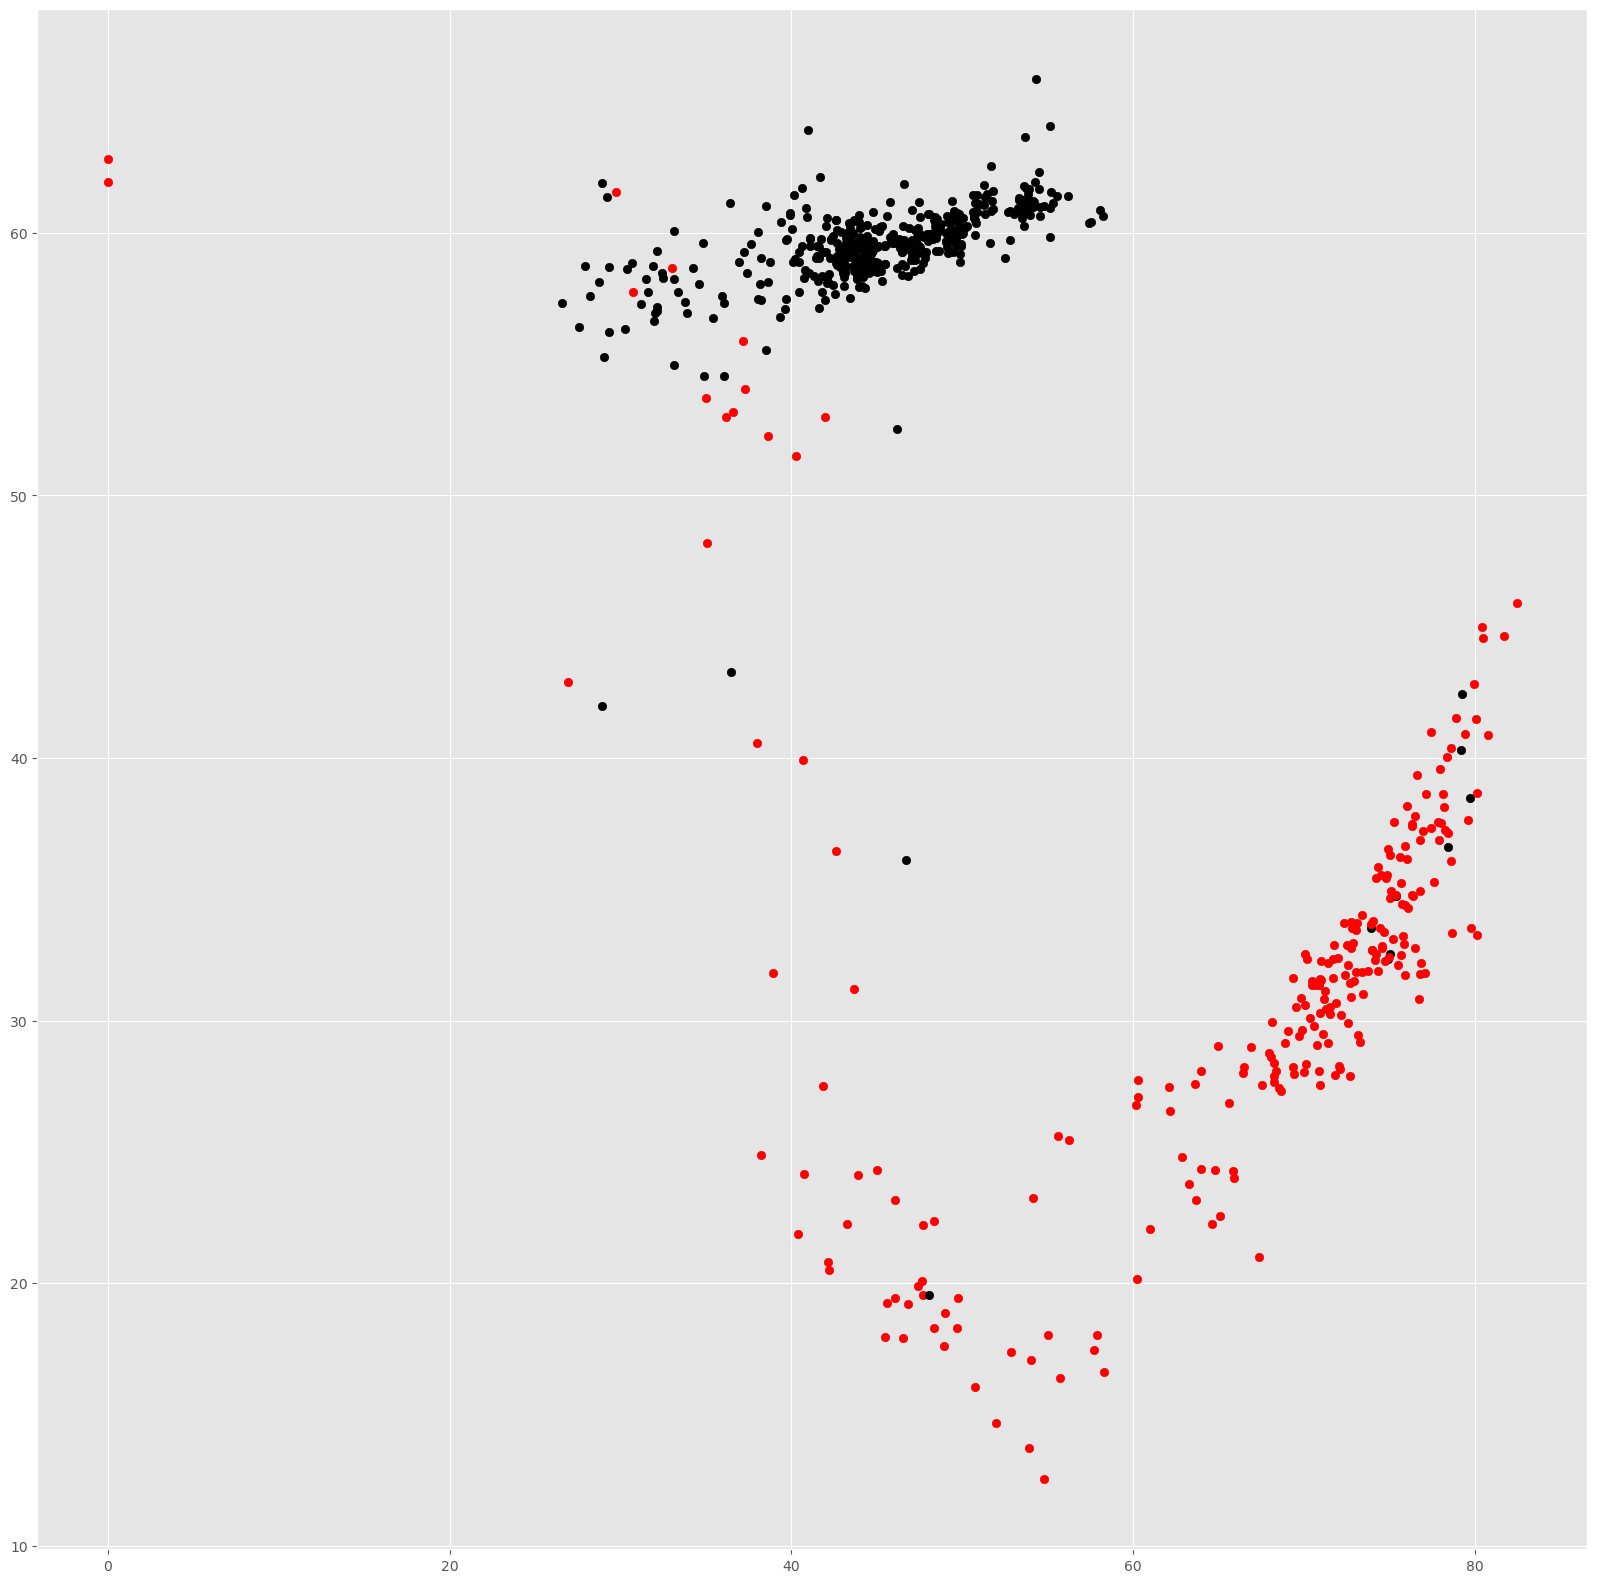

In [ ]:
w = []
i = 0
points = []
while i < len(h0_sr["0_10"]):
    x = h0_sr["20_30"][i].lp_distance( h0_sr["0_10"][i])
    if x > 125:
        w.append(i)
    y = h0_sr["10_20"][i].lp_distance( h0_sr["0_10"][i])
    points.append([x,y])
    i += 1
i = 0
plt.figure(figsize=(20,20))
while i < len(points):
    if classification[i] ==2:
        color = "black"
    else:
        color = "red"
    plt.scatter(points[i][0],points[i][1], color=color)
    i += 1
    
